In [1]:
from dataset.dataset_interface import DatasetInterface
from utils.visualization_utils import to_rgb 
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import cv2

# Mask

In [2]:
import os
import sys

THIRDPARTY_DIR = os.path.abspath("../../3rdparty/mask_rcnn")
sys.path.append(THIRDPARTY_DIR)  # To find local version of the library

from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize, config

# Directory to save logs and trained model
MODEL_DIR = Path("../../resources/networks/mask_rcnn")

# Local path to trained weights file
COCO_MODEL_PATH = MODEL_DIR / "mask_rcnn_coco.h5"
# Download COCO trained weights from Releases if needed
if not COCO_MODEL_PATH.exists():
    utils.download_trained_weights(COCO_MODEL_PATH.as_posix())

class InferenceConfig(config.Config):
    NAME = "coco"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 80  # COCO has 80 classes

config = InferenceConfig()
config.display()

model = modellib.MaskRCNN(mode='inference', model_dir=MODEL_DIR, config=config)
model.load_weights(COCO_MODEL_PATH.as_posix(), by_name=True)


/home/claudiusk/.conda/envs/depth-denoising_preprocess/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/claudiusk/.conda/envs/depth-denoising_preprocess/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/claudiusk/.conda/envs/depth-denoising_preprocess/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", n


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

Using TensorFlow backend.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [3]:
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


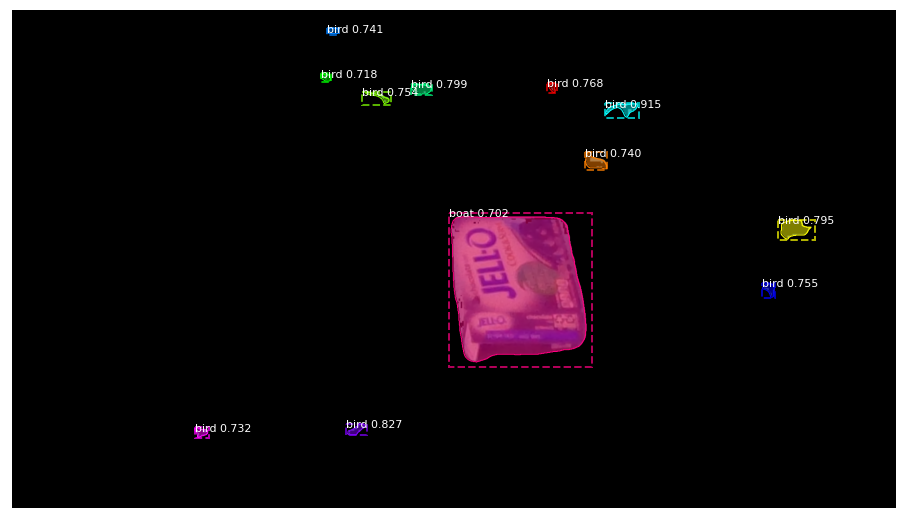

In [4]:

masked_frames = []
dataset_interface = DatasetInterface(Path("../../resources/images/calibrated"))
idx = np.random.randint(len(dataset_interface), size=(1,)).item()
# for rs_rgb, rs_depth, zv_rgb, zv_depth in dataset_interface:
rs_rgb, rs_depth, zv_rgb, zv_depth = dataset_interface[idx]
results = model.detect([rs_rgb])
r = results[0]

# visualize.display_instances(rs_rgb, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
mask = np.expand_dims(np.sum(r['masks'], axis=2) > 0, axis=2)
rs_rgb_masked = rs_rgb * mask
rs_depth_masked = np.expand_dims(rs_depth, axis=2) * mask
zv_rgb_masked = zv_rgb * mask
zv_depth_masked = np.expand_dims(zv_depth, axis=2) * mask

visualize.display_instances(rs_rgb_masked, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])
